In [1]:
# Importing packages
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

# Setting the project directory
project_dir = Path('/home/maybeabhishek/Documents/Projects/sangamML')

Using TensorFlow backend.


In [2]:
date_vars = ['date_time']

agg_ts = pd.read_csv(project_dir / 'datasets/Train.csv', parse_dates=date_vars, date_parser=pd.to_datetime)

print('aggregated timeseries shape:{}'.format(agg_ts.shape))


aggregated timeseries shape:(33750, 15)


In [ ]:
pandas_profiling.ProfileReport(agg_ts)

In [3]:
agg_ts['is_holiday_label'] = np.where(agg_ts['is_holiday'] == 'None', 0,1)
agg_ts.head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume,is_holiday_label
0,2012-10-02 09:00:00,None,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,0
1,2012-10-02 10:00:00,None,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516,0
2,2012-10-02 11:00:00,None,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,0
3,2012-10-02 12:00:00,None,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,0
4,2012-10-02 13:00:00,None,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918,0


In [4]:
agg_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 16 columns):
date_time              33750 non-null datetime64[ns]
is_holiday             33750 non-null object
air_pollution_index    33750 non-null int64
humidity               33750 non-null int64
wind_speed             33750 non-null int64
wind_direction         33750 non-null int64
visibility_in_miles    33750 non-null int64
dew_point              33750 non-null int64
temperature            33750 non-null float64
rain_p_h               33750 non-null float64
snow_p_h               33750 non-null float64
clouds_all             33750 non-null int64
weather_type           33750 non-null object
weather_description    33750 non-null object
traffic_volume         33750 non-null int64
is_holiday_label       33750 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(9), object(3)
memory usage: 4.1+ MB


In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

columns = agg_ts.columns.values
numericalColumns = np.delete(columns, [0, 1, 12, 13, 15, 16, 17, 18, 19, 20])
numericalColumns

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  import sys


array(['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
       'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h',
       'snow_p_h', 'clouds_all', 'traffic_volume'], dtype=object)

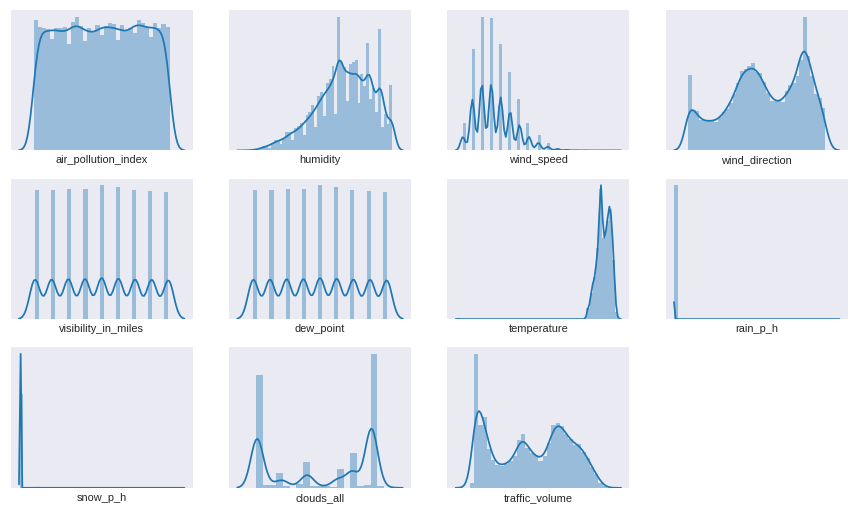

In [6]:
matplotlib.rcParams['figure.figsize'] = (15, 15)
for i in range(0, len(numericalColumns)):
    plt.subplot(5, 4, i+1)
    sns.distplot(agg_ts[numericalColumns[i]])
    plt.xticks([])
    plt.yticks([])

In [7]:
numericalColumns = numericalColumns[numericalColumns!='rain_p_h']
numericalColumns = numericalColumns[numericalColumns!='snow_p_h']
numericalColumns

array(['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
       'visibility_in_miles', 'dew_point', 'temperature', 'clouds_all',
       'traffic_volume'], dtype=object)

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15, 30)
for i in range(0, len(numericalColumns)):
    plt.subplot(5, 4, i+1)
    sns.boxplot(agg_ts[numericalColumns[i]], orient='v')
    plt.xticks([])
    plt.yticks([])

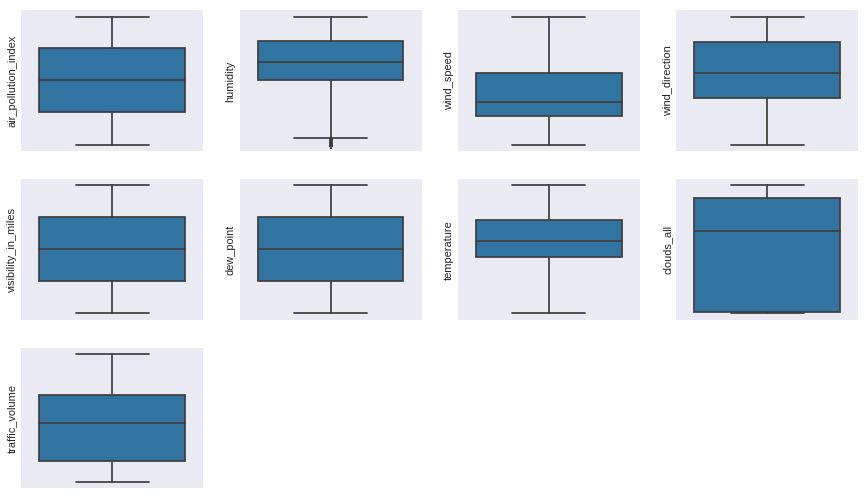

In [8]:
from scipy import stats
agg_ts = agg_ts[(np.abs(stats.zscore(agg_ts[numericalColumns])) < 3).all(axis=1)]
for i in range(0, len(numericalColumns)):
    plt.subplot(5, 4, i+1)
    sns.boxplot(agg_ts[numericalColumns[i]], orient='v')
    plt.xticks([])
    plt.yticks([])

In [9]:
categoricalColumns = np.setdiff1d(columns, numericalColumns)
categoricalColumns = categoricalColumns[categoricalColumns!='rain_p_h']
categoricalColumns = categoricalColumns[categoricalColumns!='snow_p_h']
categoricalColumns

array(['date_time', 'is_holiday', 'is_holiday_label',
       'weather_description', 'weather_type'], dtype=object)

In [10]:
agg_ts[categoricalColumns] = agg_ts[categoricalColumns].astype('category')
agg_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33487 entries, 0 to 33749
Data columns (total 16 columns):
date_time              33487 non-null category
is_holiday             33487 non-null category
air_pollution_index    33487 non-null int64
humidity               33487 non-null int64
wind_speed             33487 non-null int64
wind_direction         33487 non-null int64
visibility_in_miles    33487 non-null int64
dew_point              33487 non-null int64
temperature            33487 non-null float64
rain_p_h               33487 non-null float64
snow_p_h               33487 non-null float64
clouds_all             33487 non-null int64
weather_type           33487 non-null category
weather_description    33487 non-null category
traffic_volume         33487 non-null int64
is_holiday_label       33487 non-null category
dtypes: category(5), float64(3), int64(8)
memory usage: 4.7 MB


In [11]:
agg_ts[categoricalColumns].describe()

,date_time,is_holiday,is_holiday_label,weather_description,weather_type
count,33487,33487,33487,33487,33487
unique,28369,12,2,38,11
top,2013-04-18 22:00:00,None,0,sky is clear,Clouds
freq,6,33444,33444,7448,11123


In [12]:
agg_ts['weather_type'].cat.categories

Index(['Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain', 'Smoke',
       'Snow', 'Squall', 'Thunderstorm'],
      dtype='object')

In [13]:
agg_ts['weather_description'].cat.categories

Index(['SQUALLS', 'Sky is Clear', 'broken clouds', 'drizzle', 'few clouds',
       'fog', 'freezing rain', 'haze', 'heavy intensity drizzle',
       'heavy intensity rain', 'heavy snow', 'light intensity drizzle',
       'light intensity shower rain', 'light rain', 'light rain and snow',
       'light shower snow', 'light snow', 'mist', 'moderate rain',
       'overcast clouds', 'proximity shower rain', 'proximity thunderstorm',
       'proximity thunderstorm with drizzle',
       'proximity thunderstorm with rain', 'scattered clouds',
       'shower drizzle', 'shower snow', 'sky is clear', 'sleet', 'smoke',
       'snow', 'thunderstorm', 'thunderstorm with drizzle',
       'thunderstorm with heavy rain', 'thunderstorm with light drizzle',
       'thunderstorm with light rain', 'thunderstorm with rain',
       'very heavy rain'],
      dtype='object')

In [14]:
weather_type = agg_ts['weather_type'].cat.categories.values
weather_type = np.append(weather_type, ['squalls', 'light', 'heavy'])
weather_type

array(['Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain',
       'Smoke', 'Snow', 'Squall', 'Thunderstorm', 'squalls', 'light',
       'heavy'], dtype=object)

In [15]:
zerosCol = np.zeros(shape=(agg_ts.shape[0], len(weather_type)))
weather_type_df = pd.DataFrame(zerosCol, columns=weather_type)
weather_type_df.head()

,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Squall,Thunderstorm,squalls,light,heavy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
categoricalDF= agg_ts.copy(deep=True)
for i in weather_type:
    categoricalDF[i]=0
categoricalDF.shape

(33487, 30)

In [17]:
categoricalDF.head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,...,Haze,Mist,Rain,Smoke,Snow,Squall,Thunderstorm,squalls,light,heavy
0,2012-10-02 09:00:00,None,121,89,2,329,1,1,288.28,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2012-10-02 10:00:00,None,178,67,3,330,1,1,289.36,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2012-10-02 11:00:00,None,113,66,3,329,2,2,289.58,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2012-10-02 12:00:00,None,20,66,3,329,5,5,290.13,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2012-10-02 13:00:00,None,281,65,3,329,7,7,291.14,0.0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
for index, row in categoricalDF.iterrows():
    for i in weather_type:
        if i.lower() in row['weather_description'].lower().split(' '):
            categoricalDF.at[index,i]=1

categoricalDF[weather_type].head()

,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Squall,Thunderstorm,squalls,light,heavy
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
categoricalDF[categoricalDF['weather_description']=='thunderstorm with heavy rain']
categoricalDF[np.append(weather_type, ['weather_description'])][1080:1090]

,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Squall,Thunderstorm,squalls,light,heavy,weather_description
1090,0,0,0,0,0,0,1,0,0,0,1,0,1,0,thunderstorm with light rain
1091,0,0,0,0,0,1,0,0,0,0,0,0,0,0,mist
1092,0,0,0,0,0,0,1,0,0,0,0,0,0,1,heavy intensity rain
1093,0,0,0,0,0,0,1,0,0,0,0,0,1,0,light rain
1094,0,0,1,0,0,0,0,0,0,0,0,0,1,0,light intensity drizzle
1095,0,0,0,0,0,1,0,0,0,0,0,0,0,0,mist
1096,0,0,0,0,0,0,1,0,0,0,0,0,1,0,light rain
1097,0,0,0,0,0,1,0,0,0,0,0,0,0,0,mist
1098,0,0,1,0,0,0,0,0,0,0,0,0,0,0,drizzle
1099,0,0,0,0,0,1,0,0,0,0,0,0,0,0,mist


In [20]:
try:
    categoricalDF = categoricalDF.drop(['weather_type', 'weather_description','traffic_volume','rain_p_h', 'snow_p_h', 'is_holiday'], axis=1)
except KeyError:
    pass
categoricalDF.columns.shape

(24,)

In [21]:
numericalColumns = numericalColumns[numericalColumns!='traffic_volume']
numericalColumns.shape

(8,)

In [22]:
scaledDF = categoricalDF.copy(deep=True)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaledDF[numericalColumns] = scaler.fit_transform(scaledDF[numericalColumns])


/home/maybeabhishek/.local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/maybeabhishek/.local/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [46]:
scaledDF.columns


Index(['date_time', 'air_pollution_index', 'humidity', 'wind_speed',
       'wind_direction', 'visibility_in_miles', 'dew_point', 'temperature',
       'clouds_all', 'is_holiday_label', 'Clear', 'Clouds', 'Drizzle', 'Fog',
       'Haze', 'Mist', 'Rain', 'Smoke', 'Snow', 'Squall', 'Thunderstorm',
       'squalls', 'light', 'heavy'],
      dtype='object')

In [44]:
scaledDF['date_time'].value_counts()

2013-04-18 22:00:00    6
2013-05-19 10:00:00    6
2012-12-16 09:00:00    5
2013-12-16 10:00:00    5
2013-05-19 09:00:00    5
2013-04-18 23:00:00    5
2013-05-31 00:00:00    5
2012-10-26 04:00:00    5
2013-05-31 02:00:00    5
2013-06-01 02:00:00    5
2012-10-25 15:00:00    5
2012-11-11 09:00:00    5
2016-12-25 21:00:00    5
2012-11-11 04:00:00    5
2013-04-22 19:00:00    5
2013-05-20 17:00:00    5
2013-05-20 18:00:00    5
2013-05-21 23:00:00    5
2015-07-06 13:00:00    5
2013-05-19 06:00:00    5
2013-05-19 08:00:00    5
2015-07-06 14:00:00    5
2013-02-11 10:00:00    5
2017-04-15 07:00:00    5
2012-12-16 19:00:00    5
2013-12-03 14:00:00    5
2013-12-03 13:00:00    5
2012-12-16 21:00:00    5
2016-11-18 14:00:00    5
2016-12-25 02:00:00    5
                      ..
2016-02-24 07:00:00    1
2016-02-24 10:00:00    1
2016-02-24 11:00:00    1
2016-02-24 14:00:00    1
2016-02-22 19:00:00    1
2016-02-22 17:00:00    1
2016-02-22 15:00:00    1
2016-02-22 14:00:00    1
2016-02-21 06:00:00    1


In [43]:
train = scaledDF[:24750]
valid = scaledDF[24750:]
train = train["traffic_volume"]
valid = valid["traffic_volume"]

KeyError: 'traffic_volume'

In [42]:
n_lag = 24

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(valid, valid, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
train_data_gen.shape()

AttributeError: 'TimeseriesGenerator' object has no attribute 'shape'

In [36]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [40]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(n_lag, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./simple_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./simple_rnn.json", "w") as m:
    m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen
                                              , epochs=100
                                              , validation_data=valid_data_gen                                              , callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

Epoch 1/100


KeyError: 5634